Imports and data generation function definitions

In [424]:
import numpy as np

def sparsify_data(x, s):
    if s >= 1:
        return 0
    x -= s
    x *= (x > 0) / (1 - s)
    return x
    
def generate_data(dcount, fcount, s):
    data = np.random.rand(dcount,fcount)
    np.apply_along_axis(lambda x: sparsify_data(x, s), axis=0, arr=data)
    return data

def generate_importance_vector(fcount, base):
    result = []
    for i in range(fcount):
        result.append(base**i)
    return np.array(result)

Defining parametes and generating a dataset of 100 vectors with 20 features and a sparsity of 0.9

In [425]:
data_count = 12800000 # Amount of data vectors
feature_count = 20 # Dimensionality of each data vector
neuron_count= 5 # Dimensionality of the hidden layer (Amount of hidden layer neurons)

sparsity = 0.99
importance_base = 0.7

data = generate_data(data_count, feature_count, sparsity)
importance_vec = generate_importance_vector(feature_count, importance_base)

Training the models

In [435]:
import torch
import torch.nn.functional as F

device = torch.device("cpu")

# Initialize weights randomly, one set per activation
W1 = torch.randn(feature_count, neuron_count, dtype=torch.float32, device=device).abs() * 0.1
b1 = torch.ones(feature_count, dtype=torch.float32, device=device) * 0.5
W1.requires_grad_()
b1.requires_grad_()

W2 = torch.randn(feature_count, neuron_count, dtype=torch.float32, device=device).abs() * 0.1
b2 = torch.ones(feature_count, dtype=torch.float32, device=device) * 0.5
W2.requires_grad_()
b2.requires_grad_()

W3 = torch.randn(feature_count, neuron_count, dtype=torch.float32, device=device).abs() * 0.1
b3 = torch.ones(feature_count, dtype=torch.float32, device=device) * 0.5
W3.requires_grad_()
b3.requires_grad_()

X = torch.from_numpy(data.astype(np.float32)).to(device)
imp = torch.from_numpy(importance_vec.astype(np.float32)).to(device)

lr = 1
batch_size = 64
shuffle = True

def forward(x, W, b, activation="none"):
    h = torch.matmul(x, W)
    o = torch.matmul(h, W.t()) + b

    if activation == "relu":
        o = torch.relu(o)
    elif activation == "swiglu":
        o = F.silu(o) * torch.sigmoid(o) * (1.0 / 0.731) # Scaling so intersects x,y=1

    return o

def train(X, imp, W, b, activation="none"):
    n = X.size(0)
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    last_loss = None

    for start in range(0, n, batch_size):
        batch_idx = idx[start:start + batch_size]
        x = X[batch_idx]
        o = forward(x, W, b, activation=activation)
        loss = (((x - o) ** 2) * imp).mean()
        last_loss = loss.item()

        loss.backward()
        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            W.grad.zero_()
            b.grad.zero_()

    trained_w = W.detach().cpu().numpy()
    trained_b = b.detach().cpu().numpy()
    return [trained_w, trained_b], last_loss

result_linear, loss_linear = train(X, imp, W1, b1, activation="none")
result_linear[0] = result_linear[0] @ result_linear[0].T

result_relu, loss_relu = train(X, imp, W2, b2, activation="relu")
result_relu[0] = result_relu[0] @ result_relu[0].T

result_swiglu, loss_swiglu = train(X, imp, W3, b3, activation="swiglu")
result_swiglu[0] = result_swiglu[0] @ result_swiglu[0].T

final_losses = {
    "Linear": loss_linear,
    "ReLU": loss_relu,
    "SwiGLU": loss_swiglu,
}
average_final_loss = sum(final_losses.values()) / len(final_losses)



Visualizing the result

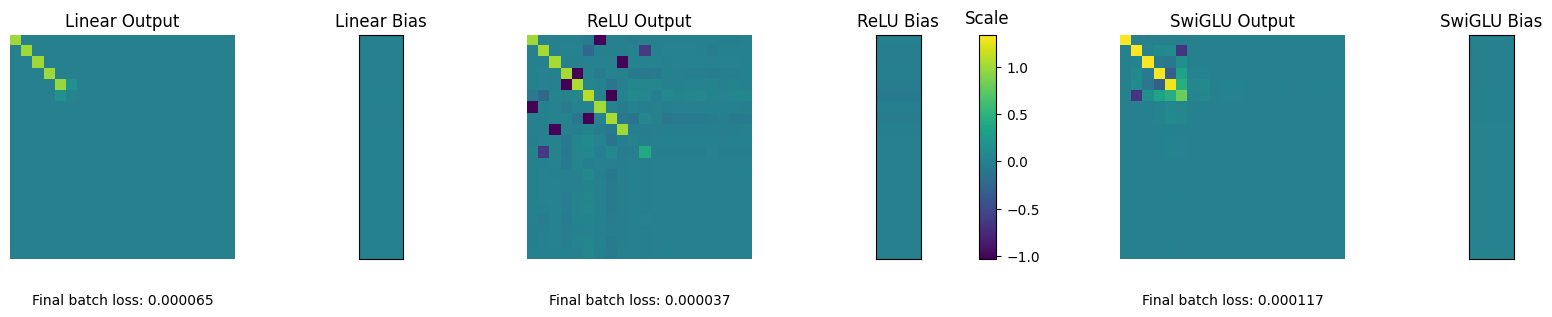

In [436]:
import matplotlib.pyplot as plt

all_values = [
    result_linear[0],
    np.asarray(result_linear[1]).reshape(-1, 1),
    result_relu[0],
    np.asarray(result_relu[1]).reshape(-1, 1),
    result_swiglu[0],
    np.asarray(result_swiglu[1]).reshape(-1, 1),
]
vmin = min(np.min(values) for values in all_values)
vmax = max(np.max(values) for values in all_values)

fig, axes = plt.subplots(1, 7, figsize=(16, 4), gridspec_kw={"width_ratios": [4, 0.5, 4, 0.5, 0.2, 4, 0.5]})
plots = [
    ("Linear Output", result_linear[0], "Linear Bias", result_linear[1]),
    ("ReLU Output", result_relu[0], "ReLU Bias", result_relu[1]),
    ("SwiGLU Output", result_swiglu[0], "SwiGLU Bias", result_swiglu[1]),
]
loss_info = [
    ("Linear", final_losses["Linear"]),
    ("ReLU", final_losses["ReLU"]),
    ("SwiGLU", final_losses["SwiGLU"]),
]

main_axes = [axes[0], axes[2], axes[5]]
bias_axes = [axes[1], axes[3], axes[6]]
colorbar_ax = axes[4]
reference_image = None

for idx, (title, values, bias_title, bias_values) in enumerate(plots):
    ax_img = main_axes[idx]
    im = ax_img.imshow(values, cmap="viridis", interpolation="nearest", vmin=vmin, vmax=vmax)
    ax_img.set_title(title)
    ax_img.axis("off")
    if reference_image is None:
        reference_image = im

    loss_label, loss_value = loss_info[idx]
    ax_img.text(0.5, -0.15, f"Final batch loss: {loss_value:.6f}", ha="center", va="top", transform=ax_img.transAxes)

    ax_bias = bias_axes[idx]
    bias_column = np.asarray(bias_values).reshape(-1, 1)
    ax_bias.imshow(bias_column, cmap="viridis", aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)
    ax_bias.set_title(bias_title)
    ax_bias.set_xticks([])
    ax_bias.set_yticks([])

fig.colorbar(reference_image, cax=colorbar_ax)
colorbar_ax.set_title("Scale", pad=8)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()



## Conclusions

We can clearly replicate the results of the original experiment with enough data.

Generally, the weights should be initialized low, and the biases should be initialized at the mean value for non-sparse features (0.5)

Increasing weight initialization scale seems to behave similarly to raising the learning rate. For most stable results, lr=1 and weight initial scale 0.1 seems to work best.

The more sparsity, the more data we need. The more batch size, the more data we need. 

Batch size effects seem to balance out by increasing training data linearly, resulting in roughly the same training speed. A batch size of 64 and 200k batches seem to work best. 

Higher batch sizes with consistent batch count could be tried, but while training speed stays roughly constant, training data generation time increases linearly, and doesn't provide much benefit.

I also added SwiGLU to see how it would perform compared to ReLU and Linear (Scaled so it intersects x,y=1). To my surprise, it seems more "conservative" compared to ReLU in forming superposition, and has a higher loss on average. It also seems more unstable, often performing even worse than linear.